In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

# Vanguard

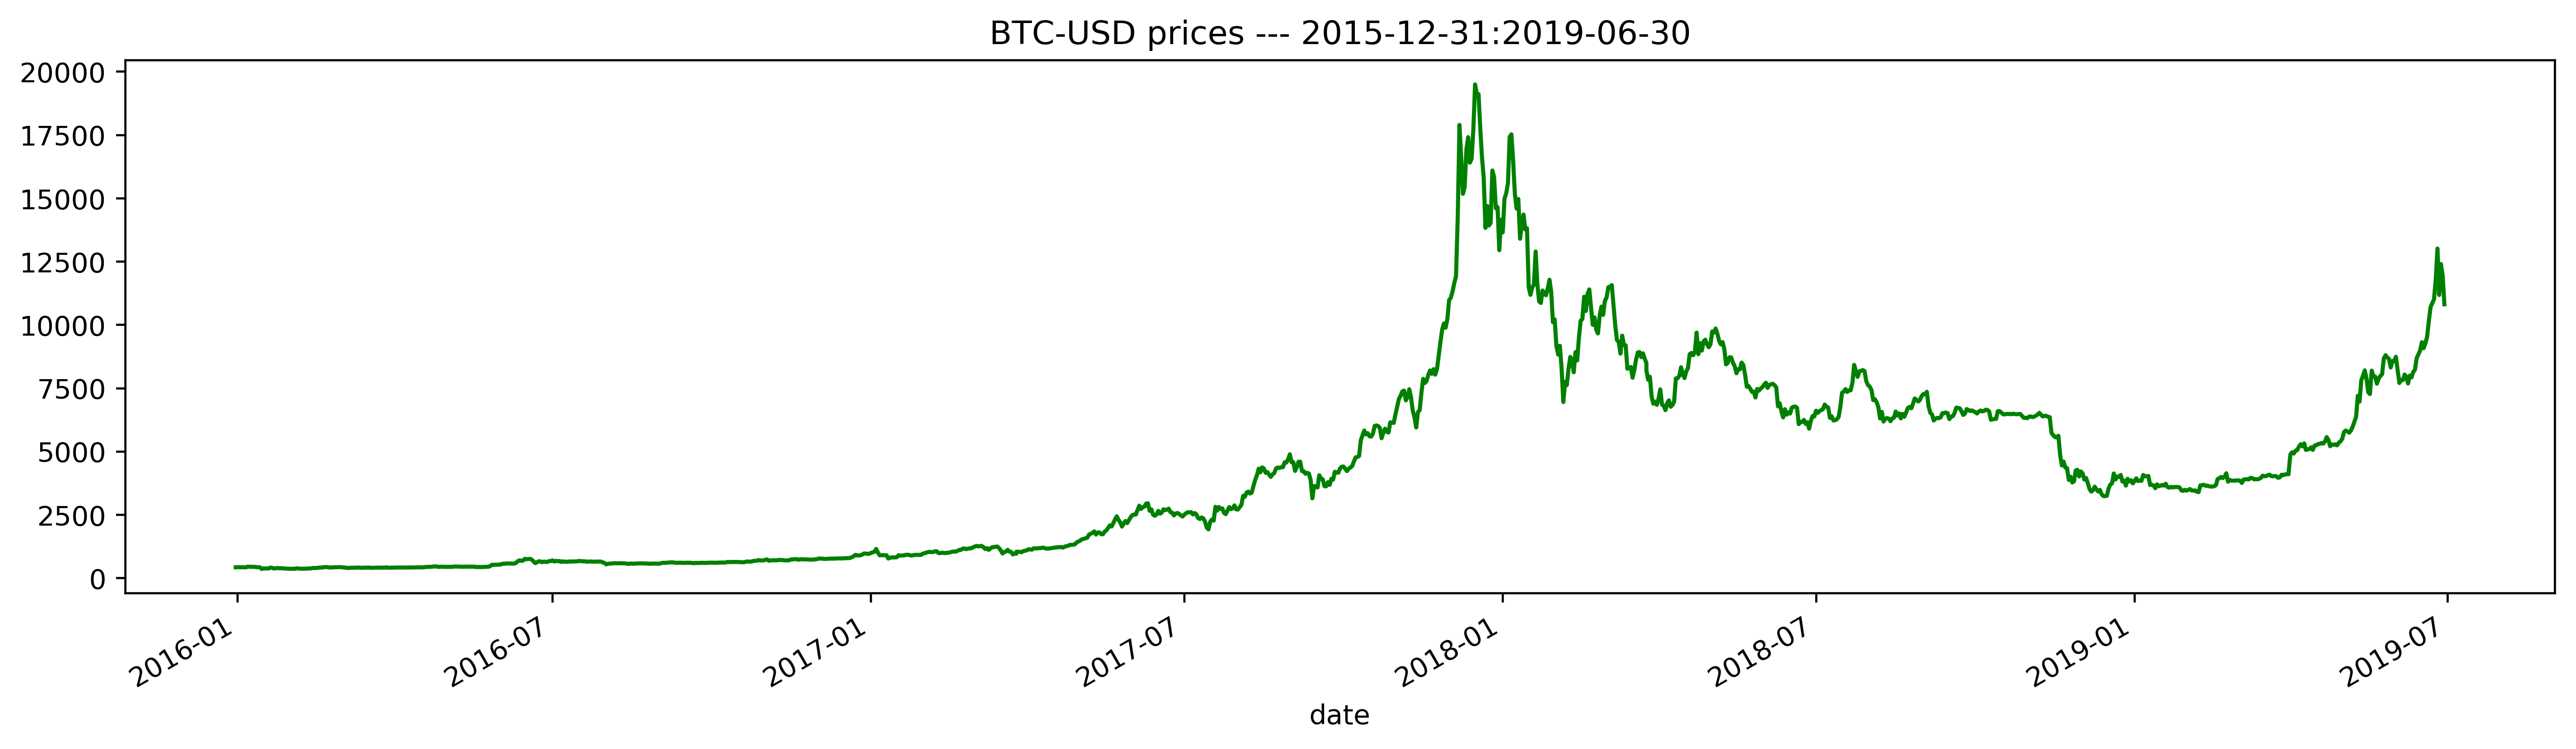

In [5]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-06-30', 
                  freq='daily', 
                  path='data/BTC.csv')

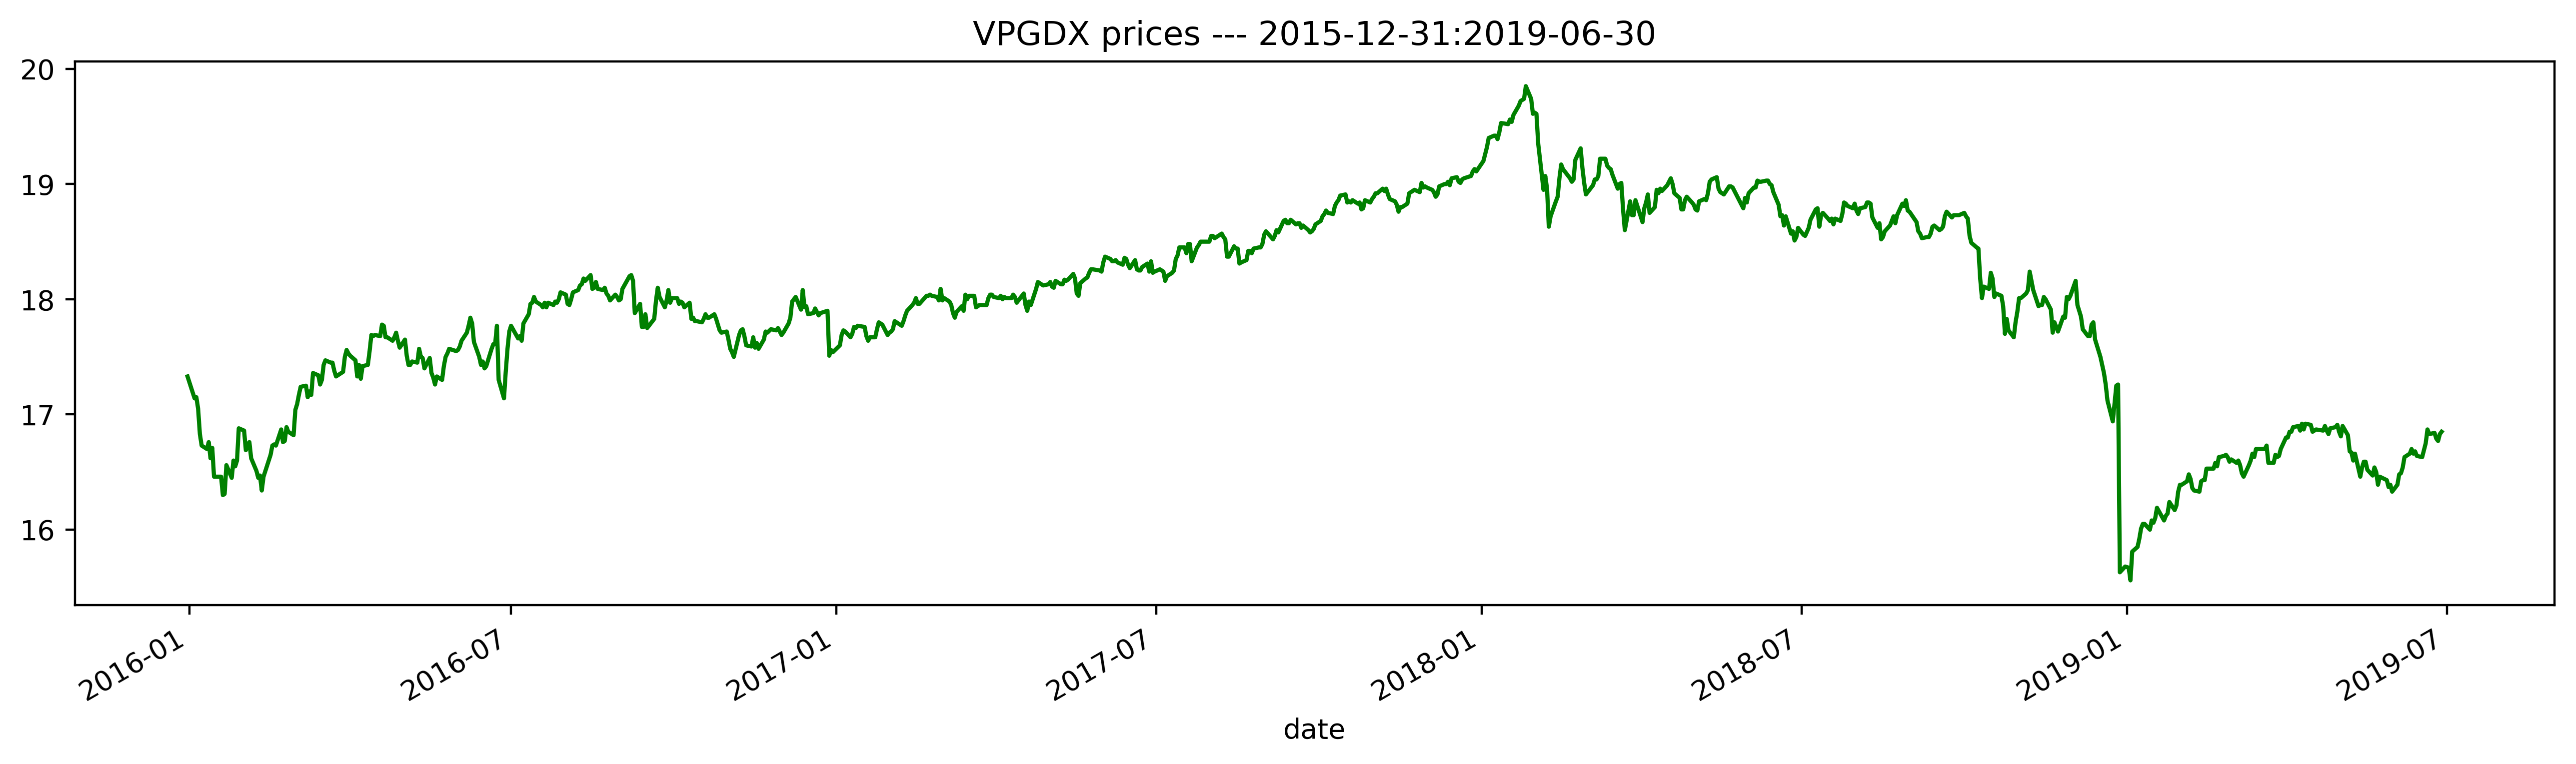

In [6]:
download_csv_data(ticker='VPGDX', 
                  start_date='2015-12-31', 
                  end_date='2019-06-30', 
                  freq='daily', 
                  path='data/VPGDX.csv')

# Симуляция с 5% BTC

In [28]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [29]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-12-31  17.330000  17.330000  13.163204
2016-01-01  17.330000  17.330000  13.163204
2016-01-02  17.330000  17.330000  13.163204
2016-01-03  17.330000  17.330000  13.163204
2016-01-04  17.139999  17.139999  13.018887
                  open       close    adjclose
date                                          
2015-12-31  425.875000  430.566986  430.566986
2016-01-01  430.721008  434.334015  434.334015
2016-01-02  434.622009  433.437988  433.437988
2016-01-03  433.578003  430.010986  430.010986
2016-01-04  430.061005  433.091003  433.091003


In [30]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-06-24  16.572435  16.572435
2019-06-25  16.523232  16.523232
2019-06-26  16.503548  16.503548
2019-06-27  16.562595  16.562595
2019-06-28  16.582279  16.582279
                    open         close
date                                  
2019-06-25  13016.231445  13016.231445
2019-06-26  11182.806641  11182.806641
2019-06-27  12407.332031  12407.332031
2019-06-28  11959.371094  11959.371094
2019-06-29  10817.155273  10817.155273


In [31]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1277 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-06-29 00:00:00+00:00
Minor_axis axis: open to close


In [32]:
WEIGHTS = [0.95, 0.05]
COMMISSION = 0.00125
DELTA = 0.025

In [33]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_count = 0
    
    context.time = 0

In [34]:
def handle_data(context, data):
    
    if context.time == 0:
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
        context.time += 1
    
    else:
        for i, asset in enumerate(context.assets):
            if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                order_target_percent(asset, context.weights[i])
                
                context.rebalance_count += 1
                
        context.time += 1
        

In [35]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [36]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [37]:
qf.get_performance_summary(returns)

annual_volatility     0.075666
annualized_returns    0.144726
cumulative_returns    0.603206
max_drawdown         -0.135237
sharpe_ratio          1.824645
sortino_ratio         2.693179
dtype: float64

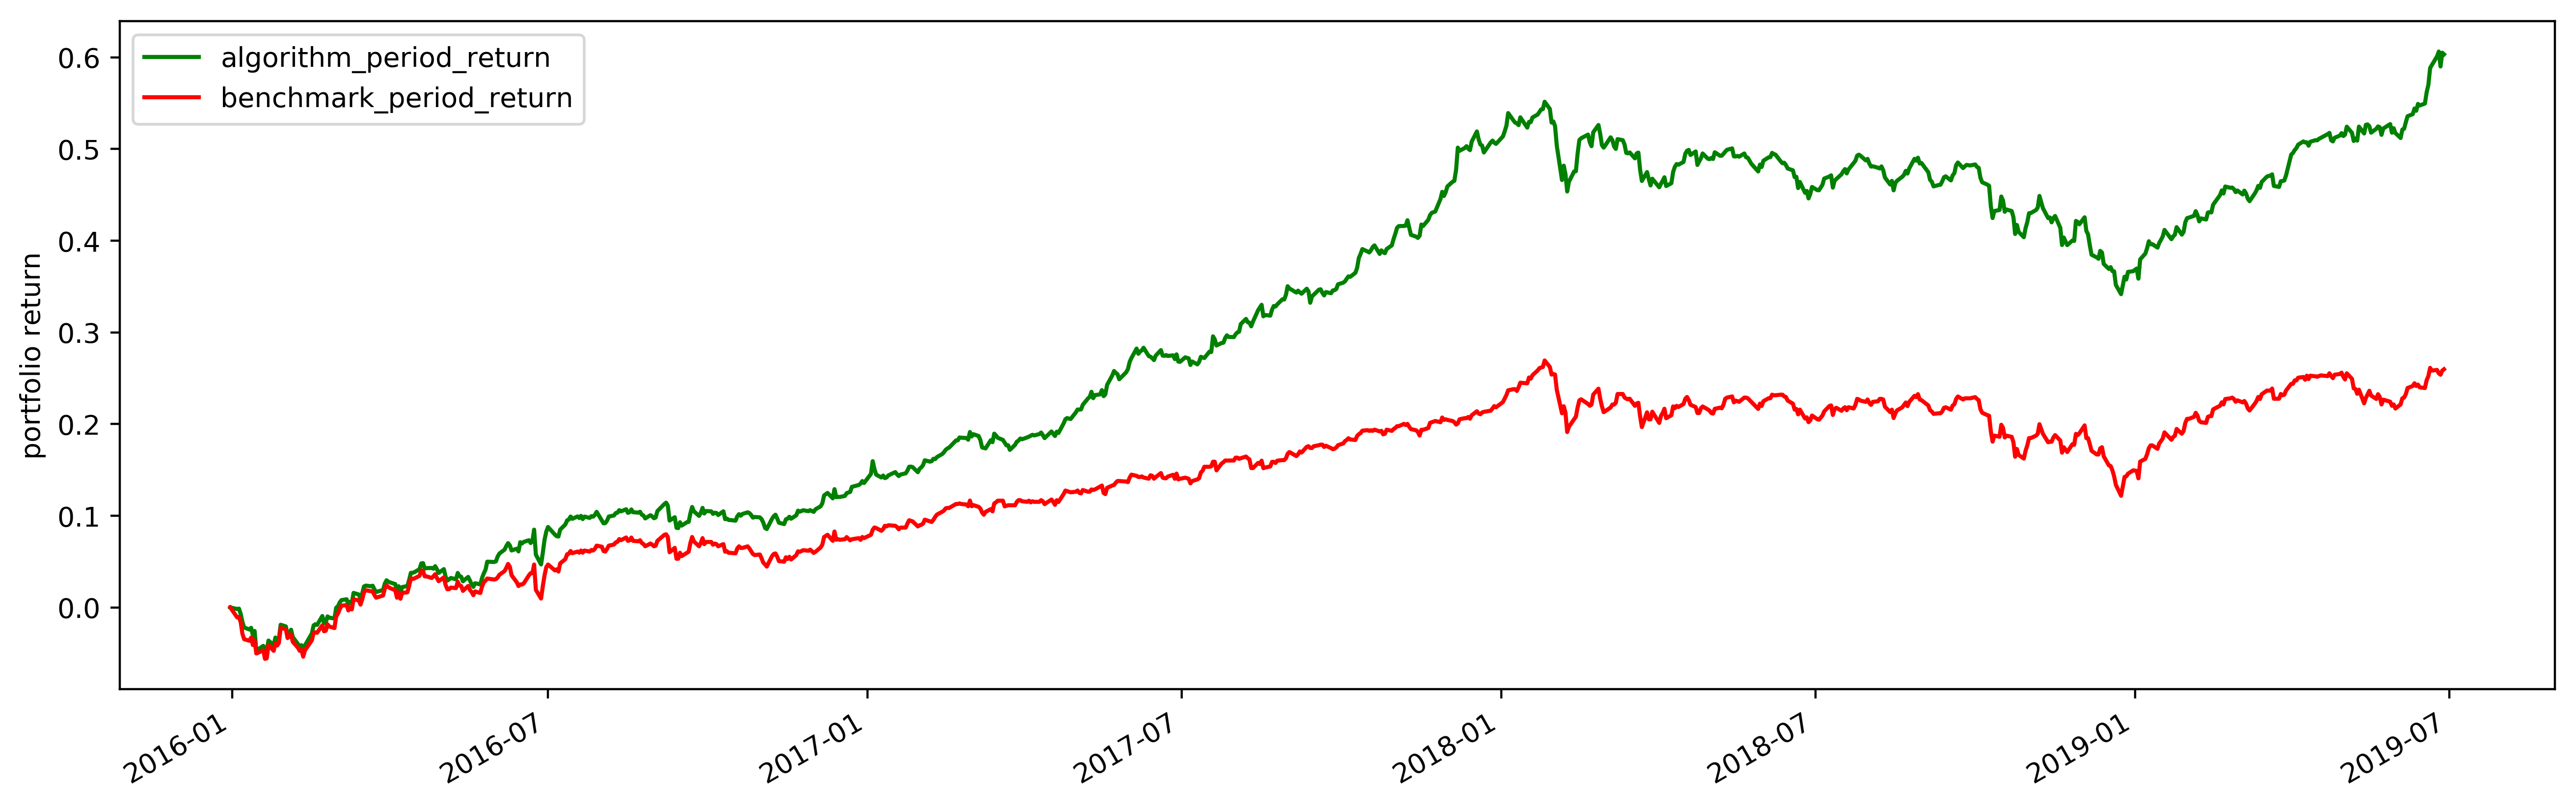

Final portfolio return: 60.32%
Final benchmark return: 25.97%


In [38]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [39]:
(perf.portfolio_value/100000).tail()

2019-06-24 00:00:00+00:00    160.098635
2019-06-25 00:00:00+00:00    160.622164
2019-06-26 00:00:00+00:00    158.995950
2019-06-27 00:00:00+00:00    160.496716
2019-06-28 00:00:00+00:00    160.320635
Name: portfolio_value, dtype: float64

In [40]:
bitcoin5 = perf.algorithm_period_return

In [41]:
bitcoinPortfolio5 = 1000 * (1 + bitcoin5)

bitcoinPortfolio5 = bitcoinPortfolio5.rename('BTC 5% Target') 

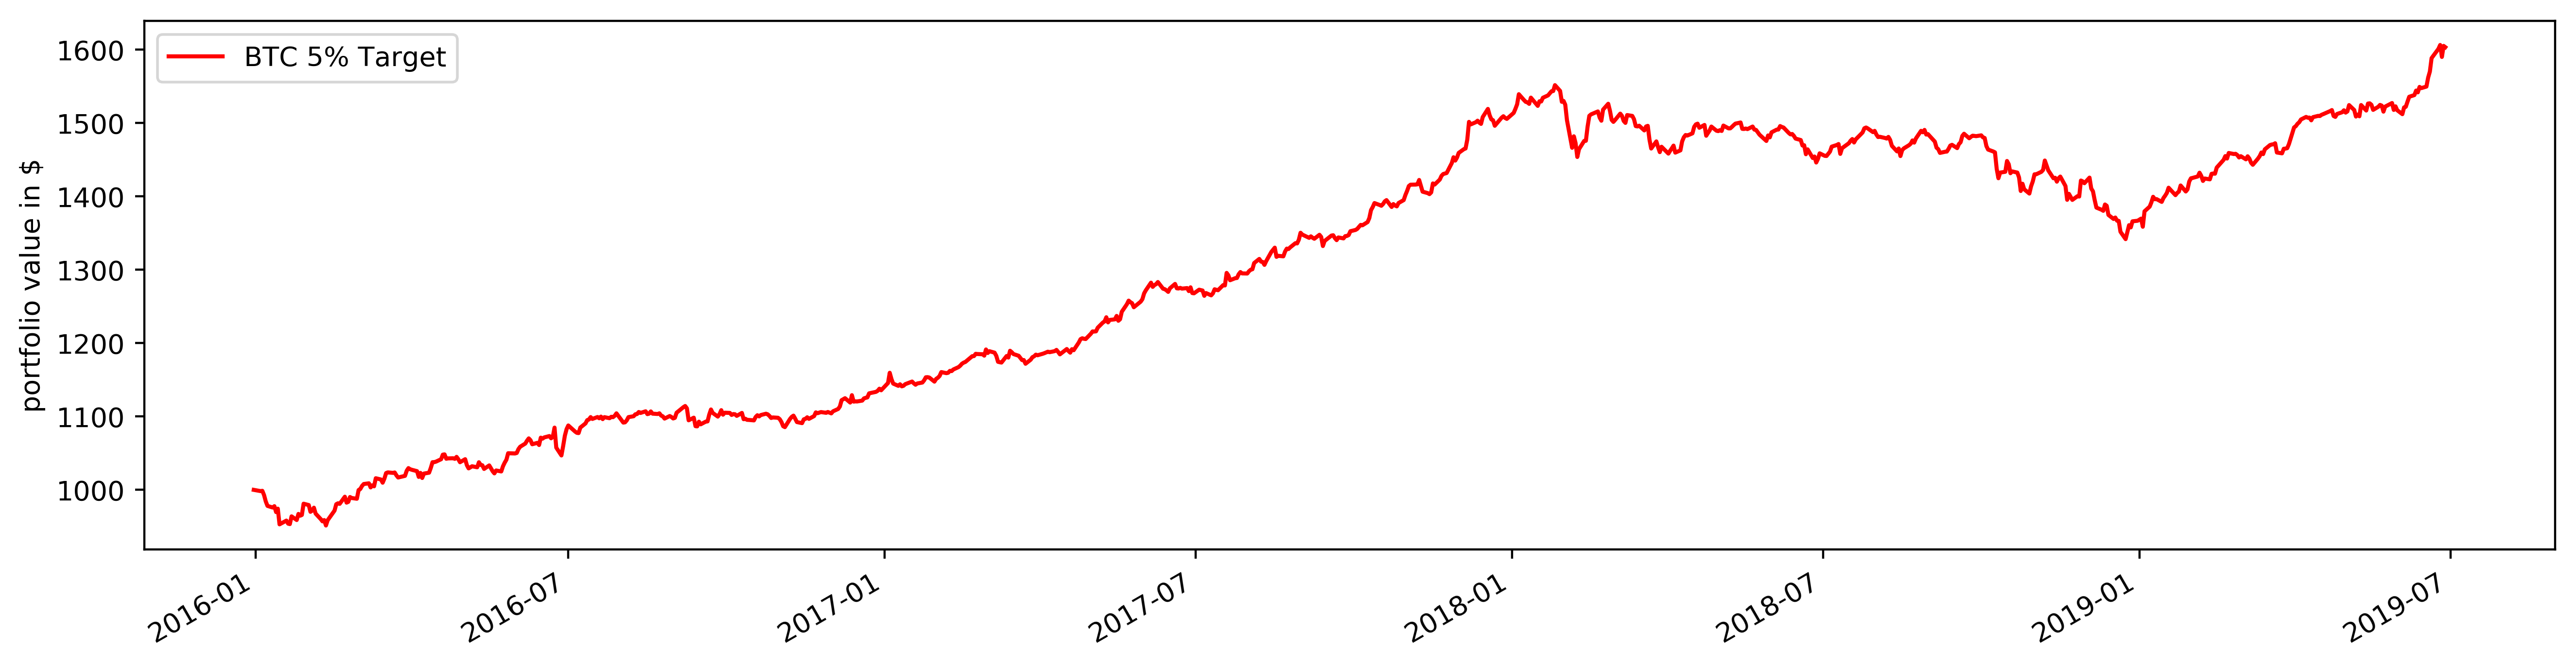

In [42]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio5.plot(color='r')
#portfolio1.plot(color='gold')
#vanguard.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [43]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.head()

,Equity(0 [BTC]),Equity(1 [VPGDX]),cash
2016-01-04,502818.654968,9.395835e+06,84017.92931
2016-01-05,501505.550079,9.401316e+06,84017.92931
2016-01-06,498190.917755,9.346500e+06,84017.92931
2016-01-07,531793.732819,9.225900e+06,84017.92931
2016-01-08,526200.042755,9.171084e+06,84017.92931


In [44]:
# Поправляем названия столбцов

weights_df.columns = ['BTC', 'VPGDX', 'Cash']

In [45]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])

In [46]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [47]:
norm_weights_df.tail()

,BTC,VPGDX,Cash
2019-06-24,0.058182,0.935063,0.006755
2019-06-25,0.064019,0.929248,0.006733
2019-06-26,0.055564,0.937634,0.006802
2019-06-27,0.061072,0.932190,0.006739
2019-06-28,0.058931,0.934323,0.006746


ValueError: When stacked is True, each column must be either all positive or negative.Cash contains both positive and negative values

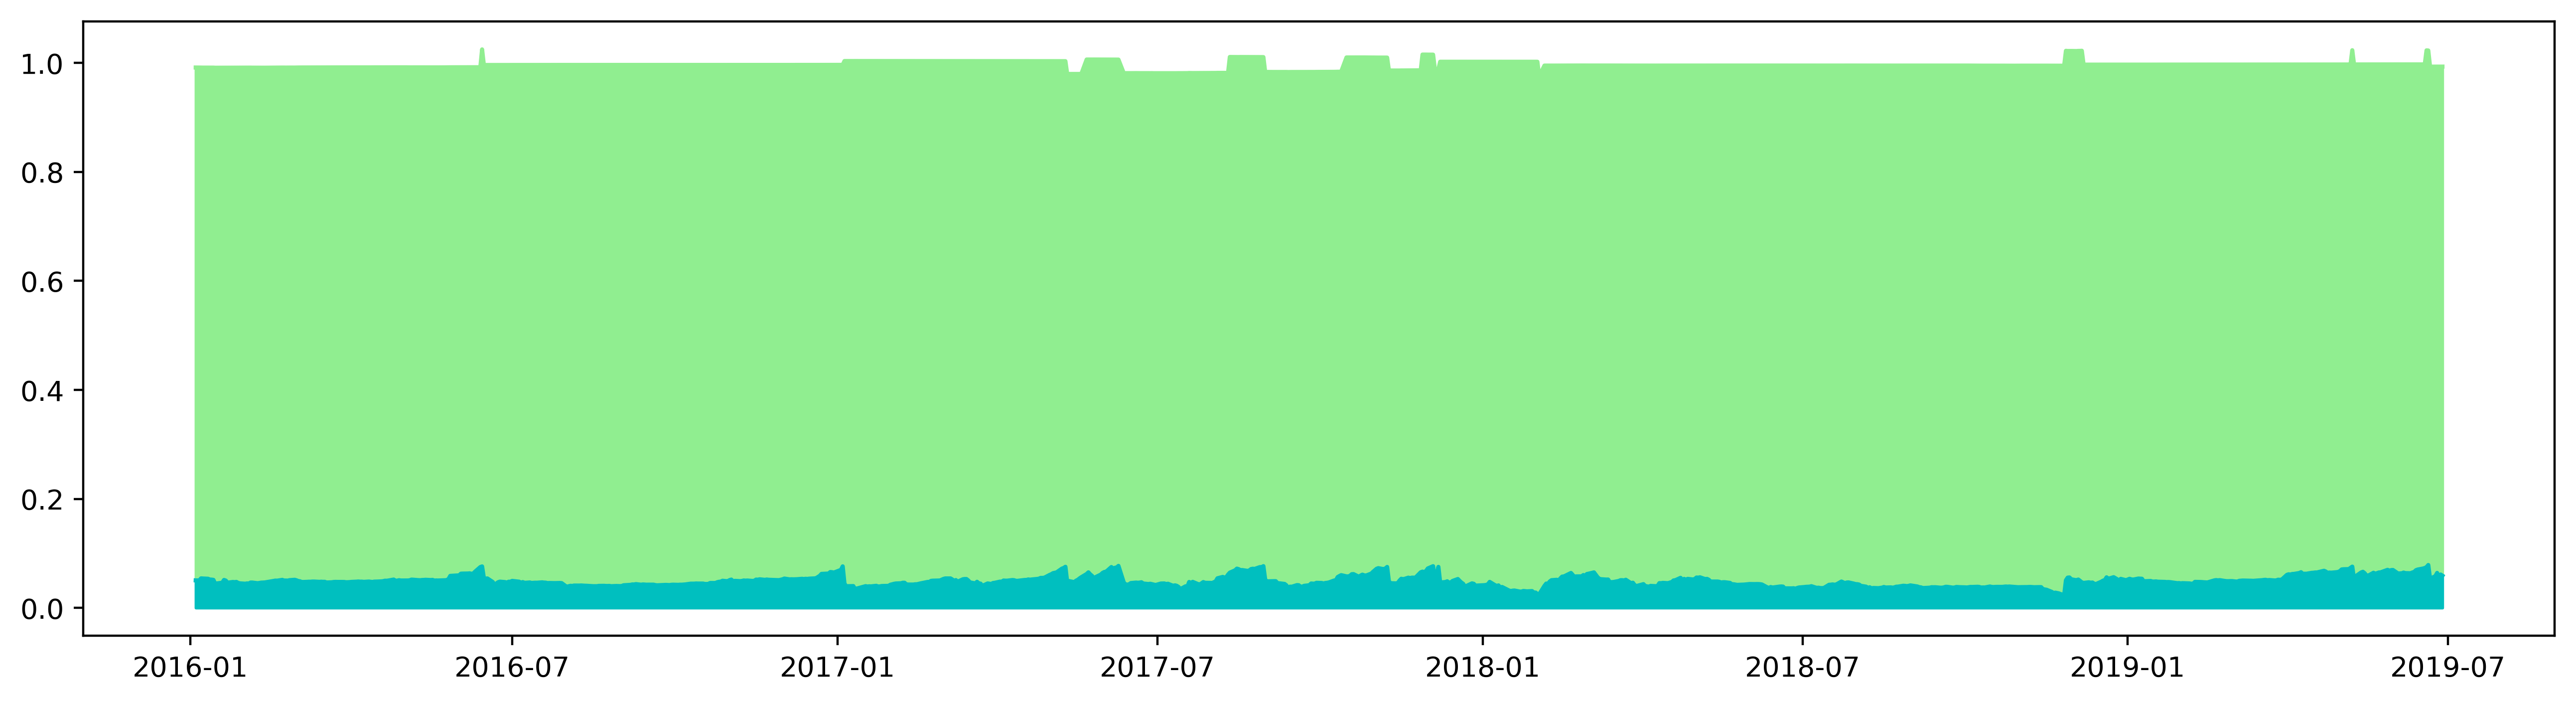

In [48]:
norm_weights_df = norm_weights_df[['BTC', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Симуляция с 1% Bitcoin

In [49]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX', 'BTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [50]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-12-31  17.330000  17.330000  13.163204
2016-01-01  17.330000  17.330000  13.163204
2016-01-02  17.330000  17.330000  13.163204
2016-01-03  17.330000  17.330000  13.163204
2016-01-04  17.139999  17.139999  13.018887
                  open       close    adjclose
date                                          
2015-12-31  425.875000  430.566986  430.566986
2016-01-01  430.721008  434.334015  434.334015
2016-01-02  434.622009  433.437988  433.437988
2016-01-03  433.578003  430.010986  430.010986
2016-01-04  430.061005  433.091003  433.091003


In [51]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-06-24  16.572435  16.572435
2019-06-25  16.523232  16.523232
2019-06-26  16.503548  16.503548
2019-06-27  16.562595  16.562595
2019-06-28  16.582279  16.582279
                    open         close
date                                  
2019-06-25  13016.231445  13016.231445
2019-06-26  11182.806641  11182.806641
2019-06-27  12407.332031  12407.332031
2019-06-28  11959.371094  11959.371094
2019-06-29  10817.155273  10817.155273


In [52]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1277 (major_axis) x 2 (minor_axis)
Items axis: VPGDX to BTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-06-29 00:00:00+00:00
Minor_axis axis: open to close


In [53]:
WEIGHTS = [0.98, 0.01]
COMMISSION = 0.00125
DELTA = 0.025

In [54]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_count = 0
    
    context.time = 0

In [55]:
def handle_data(context, data):
    
    if context.time == 0:
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
        context.time += 1
    
    else:
        for i, asset in enumerate(context.assets):
            if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                order_target_percent(asset, context.weights[i])
                
                context.rebalance_count += 1
                
        context.time += 1

In [56]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [57]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [58]:
qf.get_performance_summary(returns)

annual_volatility     0.068569
annualized_returns    0.088525
cumulative_returns    0.344750
max_drawdown         -0.122555
sharpe_ratio          1.271549
sortino_ratio         1.799104
dtype: float64

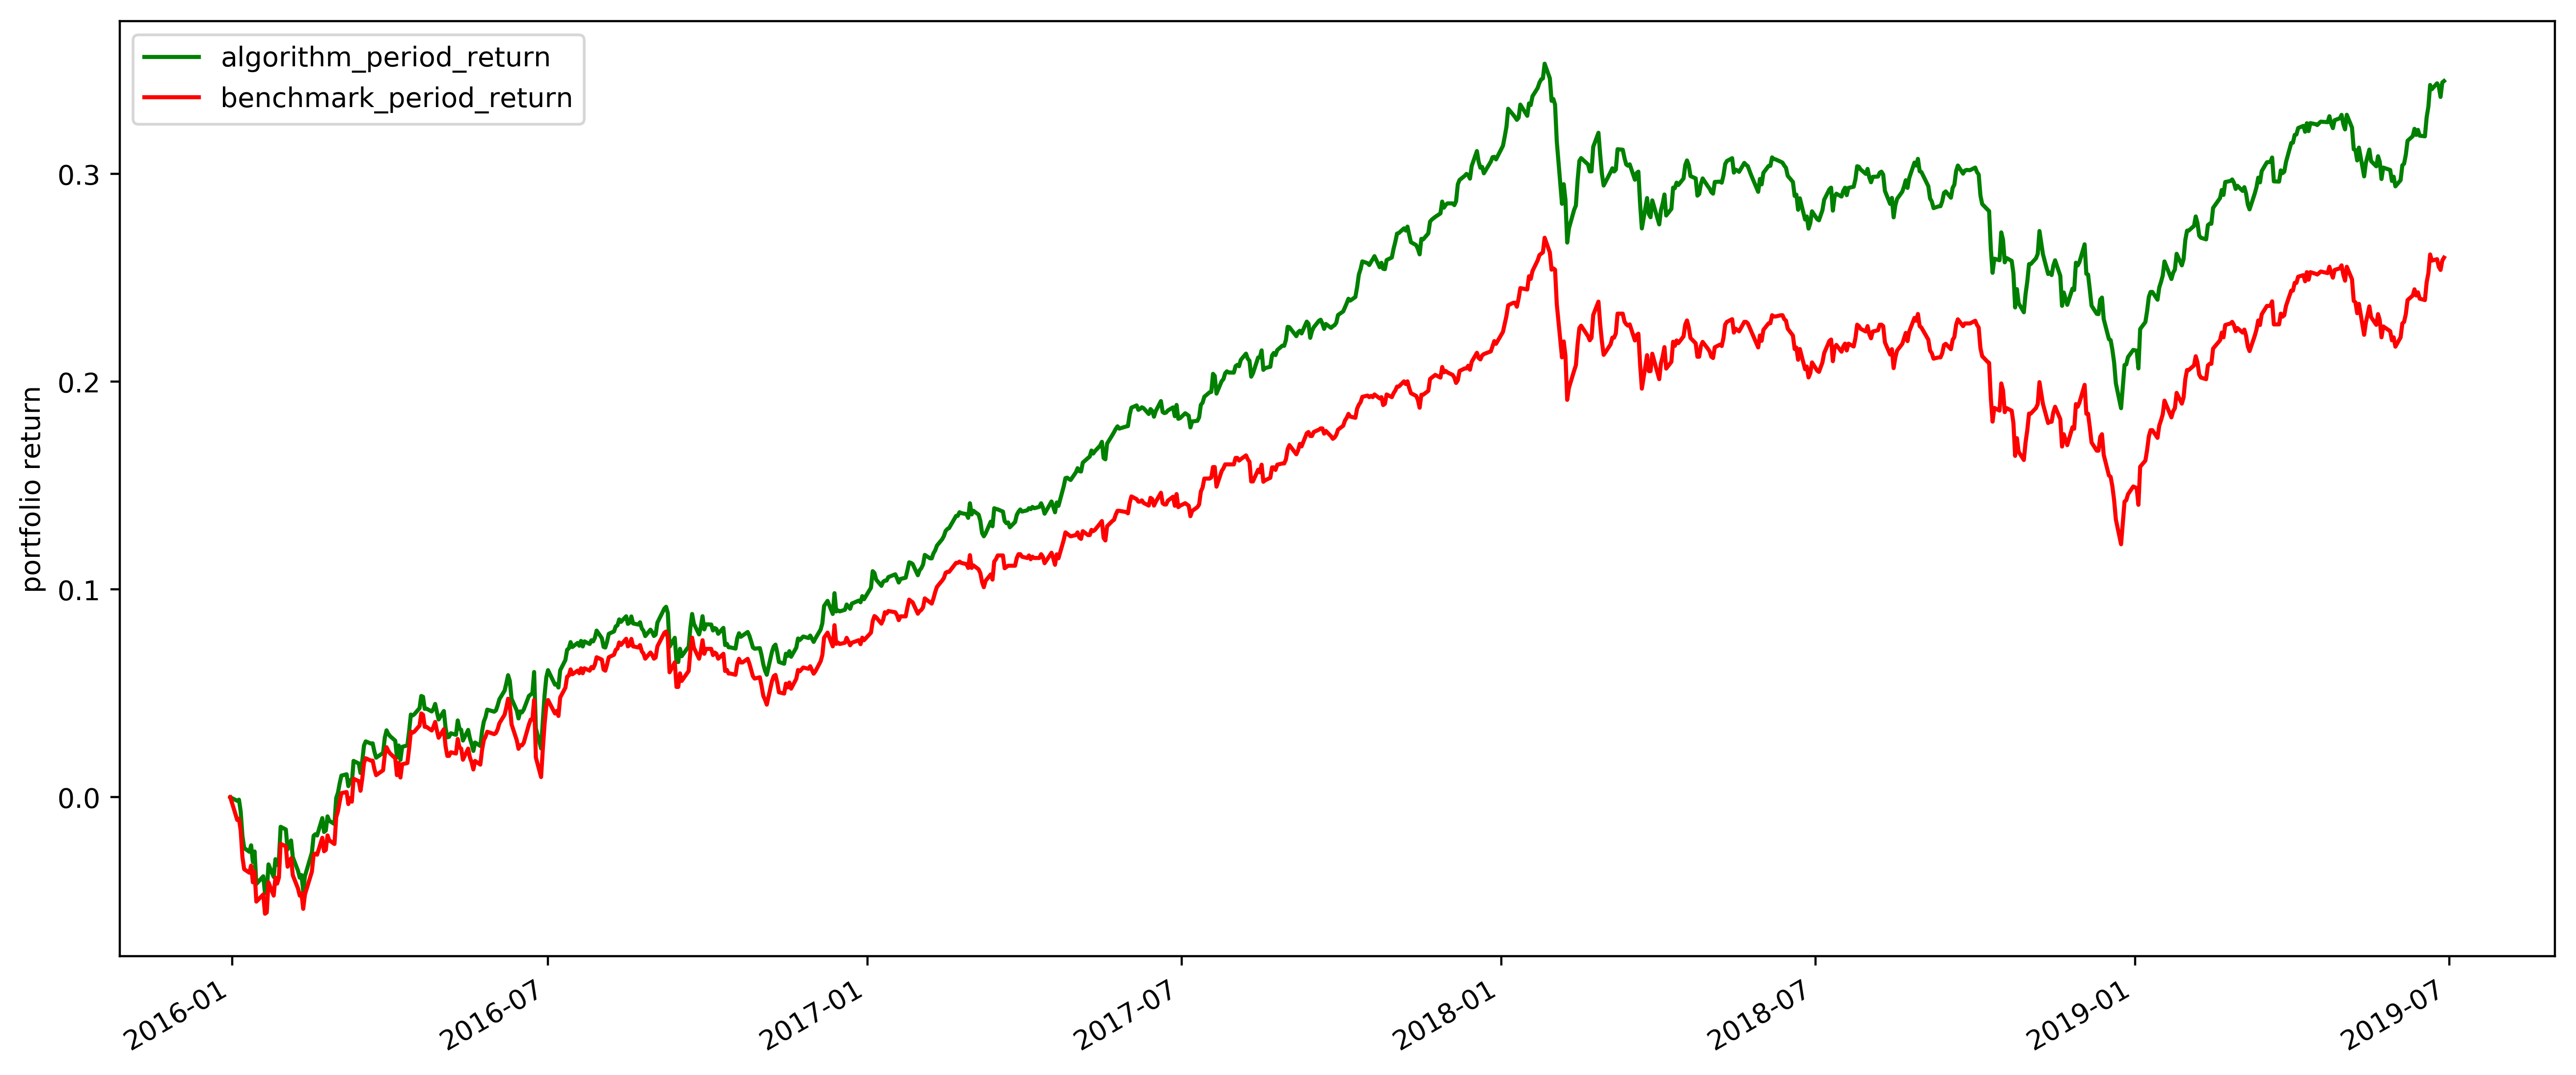

Final portfolio return: 34.47%
Final benchmark return: 25.97%


In [59]:
fig, ax = plt.subplots(figsize=[16, 7])

# portfolio value
perf.algorithm_period_return.plot(color='g')
perf.benchmark_period_return.plot(color='r')

ax.set_ylabel('portfolio return')

plt.legend()
plt.show()

print('Final portfolio return: {}%'.format(np.round(perf.algorithm_period_return[-1] * 100, 2)))
print('Final benchmark return: {}%'.format(np.round(perf.benchmark_period_return[-1] * 100, 2)))

In [60]:
bitcoin1 = perf.algorithm_period_return

In [61]:
vanguard = perf.benchmark_period_return

In [62]:
bitcoinPortfolio1 = 1000 * (1 + bitcoin1)
benchmark = 1000 * (1 + vanguard)

bitcoinPortfolio1 = bitcoinPortfolio1.rename('BTC 1% Target')
benchmark = benchmark.rename('VPGDX') 

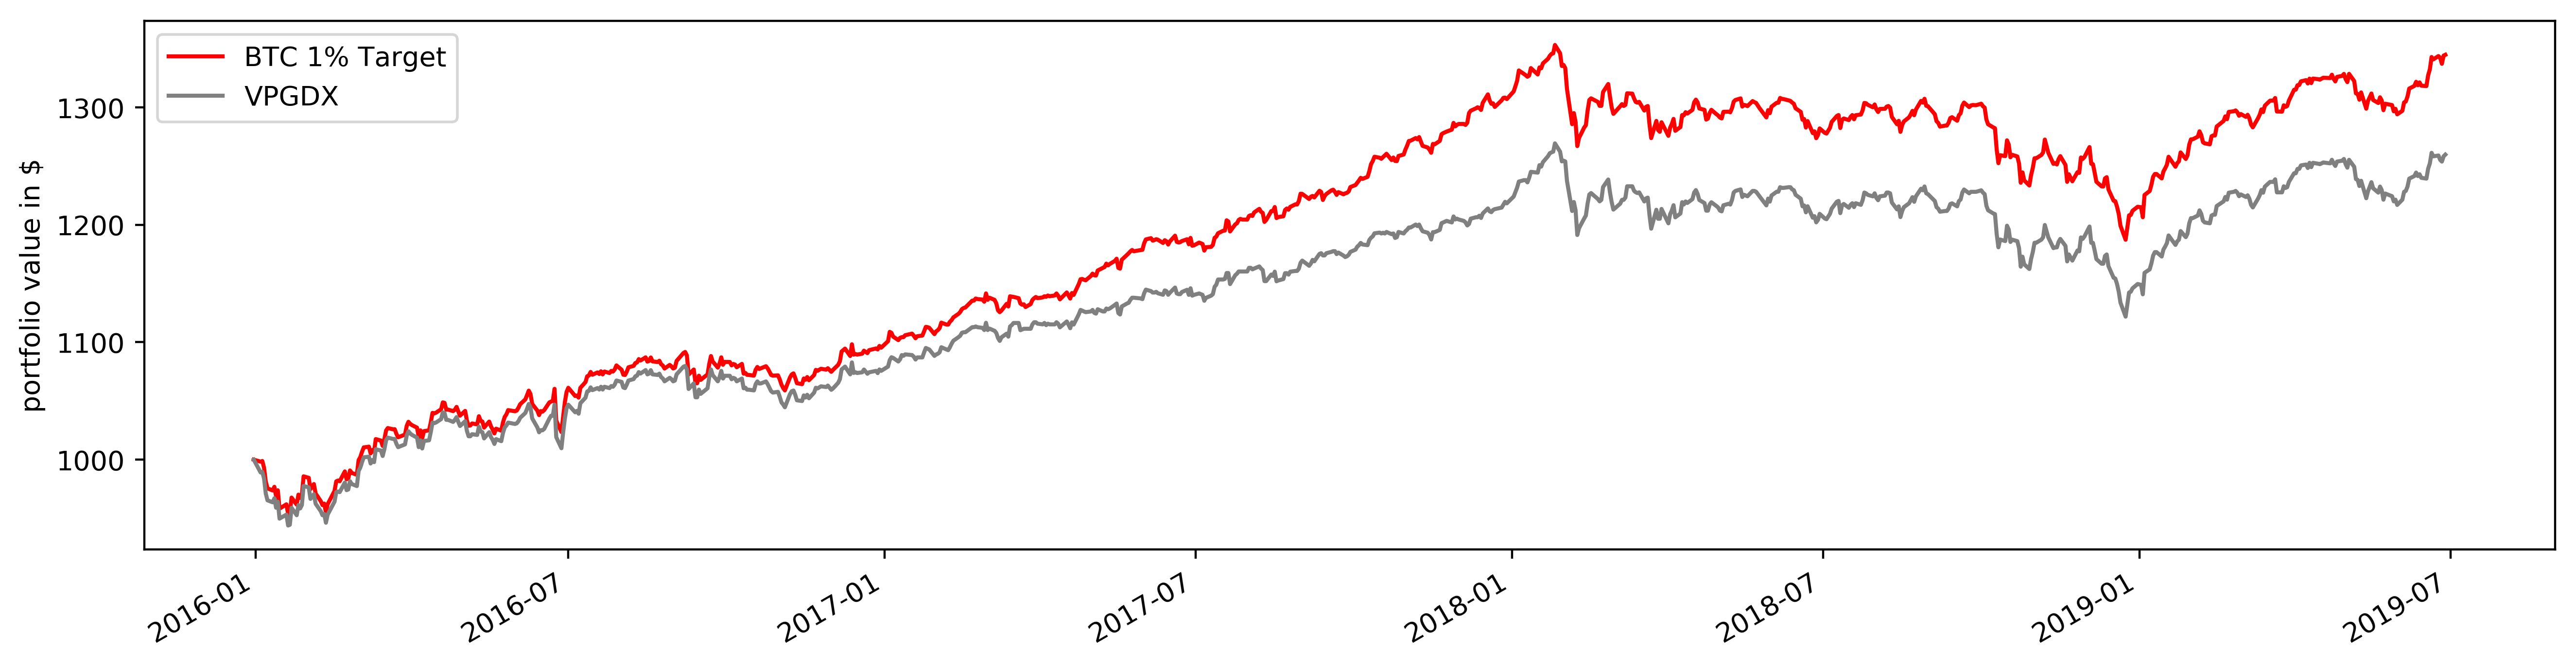

In [63]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
bitcoinPortfolio1.plot(color='r')
benchmark.plot(color='gray')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [64]:
#Поправляем индексацию

new_index = pd.Series(pd.to_datetime(positions.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(positions, index=new_index)
weights_df.tail()

,Equity(0 [BTC]),Equity(1 [VPGDX]),cash
2019-06-24,224027.422852,1.300210e+07,210445.729851
2019-06-25,247308.397461,1.296350e+07,210445.729851
2019-06-26,212473.326172,1.294806e+07,210445.729851
2019-06-27,235739.308594,1.299438e+07,210445.729851
2019-06-28,227228.050781,1.300983e+07,210445.729851


In [65]:
# Поправляем названия столбцов

weights_df.columns = ['BTC', 'VPGDX', 'Cash']

In [66]:
# Нормирование весов в файле

norm_weights_df = weights_df.copy()

norm_weights_df['BTC'] = weights_df['BTC']/(weights_df['BTC'] + weights_df['VPGDX'] + weights_df['Cash'])    
norm_weights_df['VPGDX'] = weights_df['VPGDX']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])
norm_weights_df['Cash'] = weights_df['Cash']/(weights_df['VPGDX'] + weights_df['BTC'] + weights_df['Cash'])

In [67]:
# convert date objects from pandas format to python datetime
norm_weights_df.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in norm_weights_df.index]

In [68]:
norm_weights_df.tail()

,BTC,VPGDX,Cash
2019-06-24,0.016673,0.967665,0.015662
2019-06-25,0.018427,0.965893,0.015680
2019-06-26,0.015891,0.968370,0.015739
2019-06-27,0.017539,0.966803,0.015658
2019-06-28,0.016897,0.967453,0.015649


ValueError: When stacked is True, each column must be either all positive or negative.Cash contains both positive and negative values

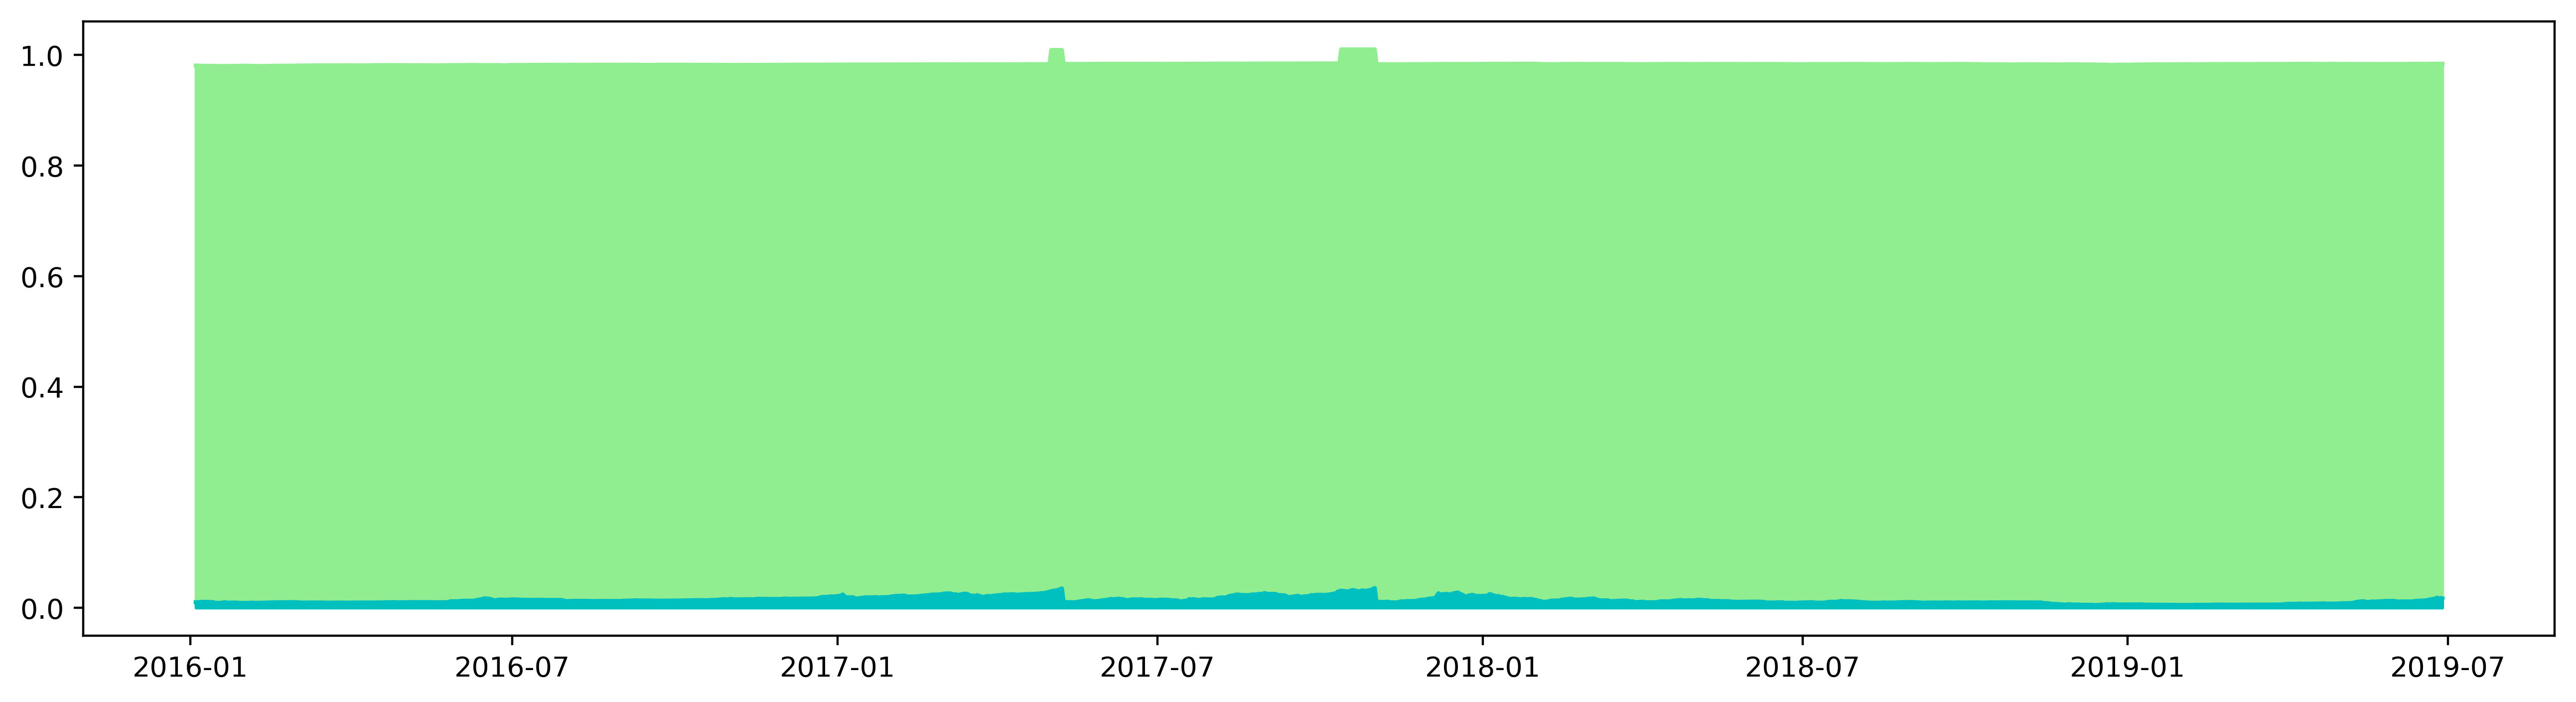

In [69]:
norm_weights_df = norm_weights_df[['BTC', 'VPGDX', 'Cash']]
# plot the results
col = ['c', 'lightgreen', 'seagreen']
ax = norm_weights_df.plot(kind='area', stacked=True, color = col) # stacked=True показывает веса в одном столбце

# set monthly locator

##### Градуировка https://matplotlib.org/3.1.0/gallery/ticks_and_spines/tick-locators.html
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis = 'both', direction = 'out')
ax.set(title = 'Paradigm strategy', ylabel='Allocation')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

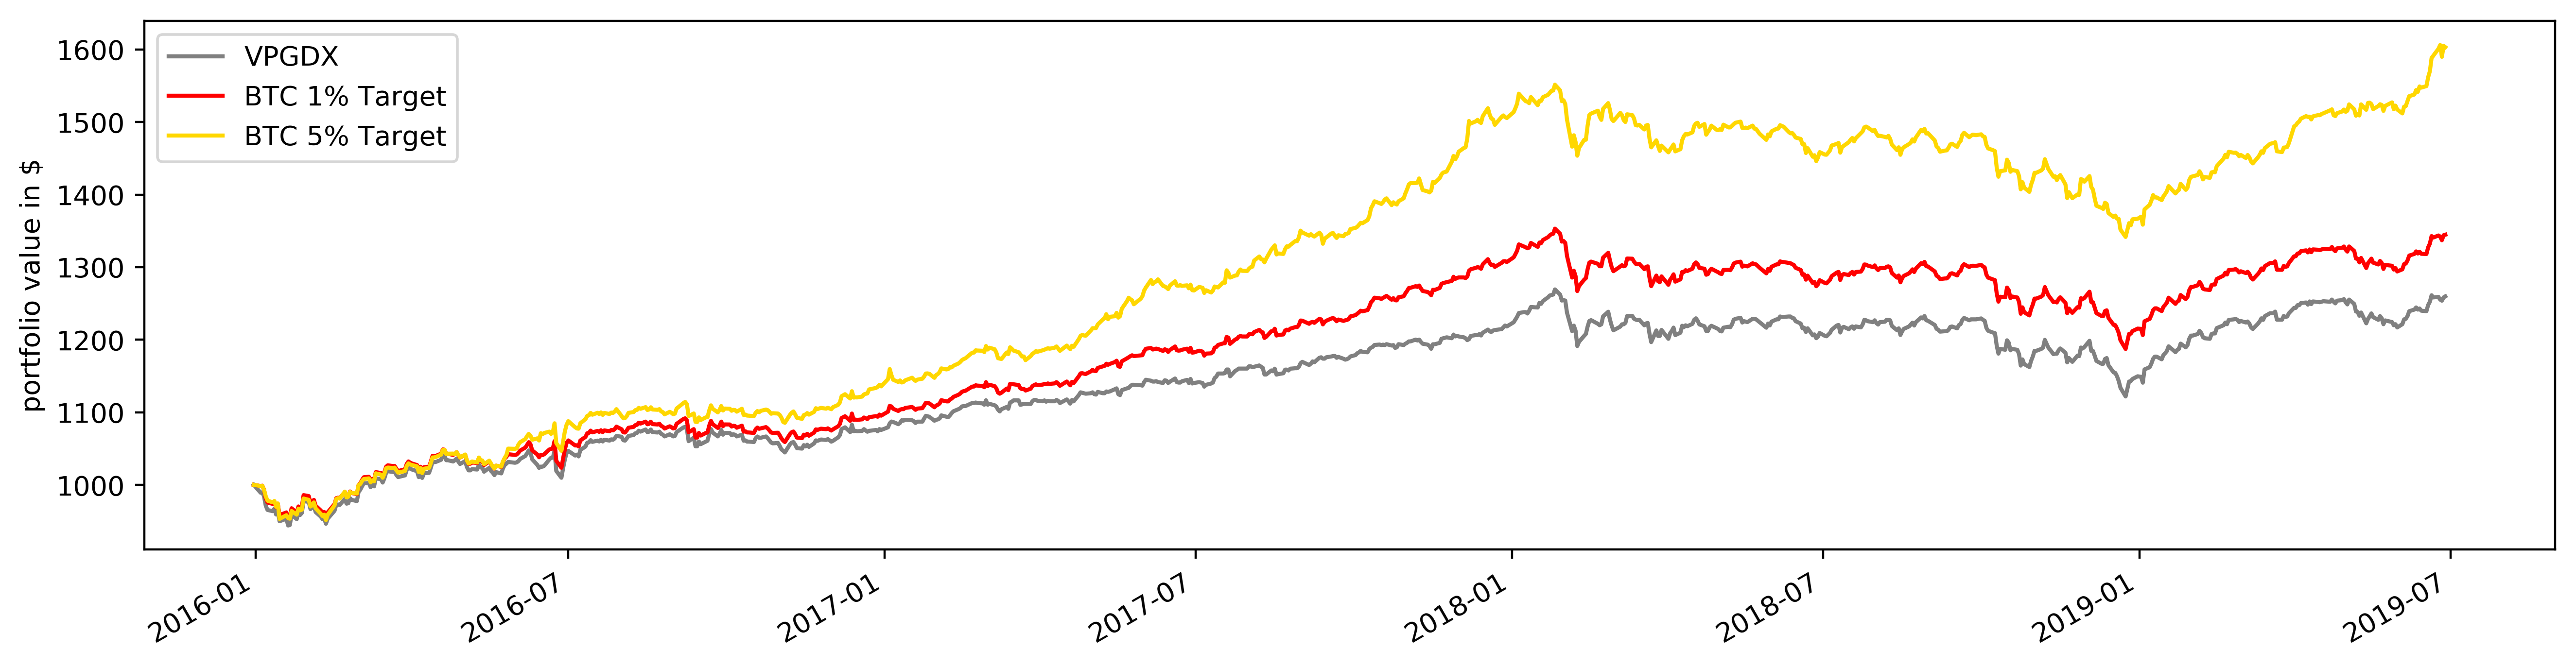

In [70]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
benchmark.plot(color='gray')
bitcoinPortfolio1.plot(color='r')
bitcoinPortfolio5.plot(color='gold')

ax.set_ylabel('portfolio value in $')

plt.legend()
plt.show()

In [71]:
#fig.savefig('vanguard.png', transparent=False, dpi=800, bbox_inches="tight")

# Просадки

In [72]:
window = 365

In [73]:
# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 365 days data have an expanding window
Roll_Max1 = pd.rolling_max(bitcoinPortfolio1, window, min_periods=1)
Roll_Max2 = pd.rolling_max(bitcoinPortfolio5, window, min_periods=1)
Roll_Max3 = pd.rolling_max(benchmark, window, min_periods=1)
Daily_Drawdown1 = bitcoinPortfolio1/Roll_Max1 - 1.0
Daily_Drawdown2 = bitcoinPortfolio5/Roll_Max2 - 1.0
Daily_Drawdown3 = benchmark/Roll_Max3 - 1.0

In [74]:
# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown1 = pd.rolling_min(Daily_Drawdown1, window, min_periods=1)
Max_Daily_Drawdown2 = pd.rolling_min(Daily_Drawdown2, window, min_periods=1)
Max_Daily_Drawdown3 = pd.rolling_min(Daily_Drawdown3, window, min_periods=1)

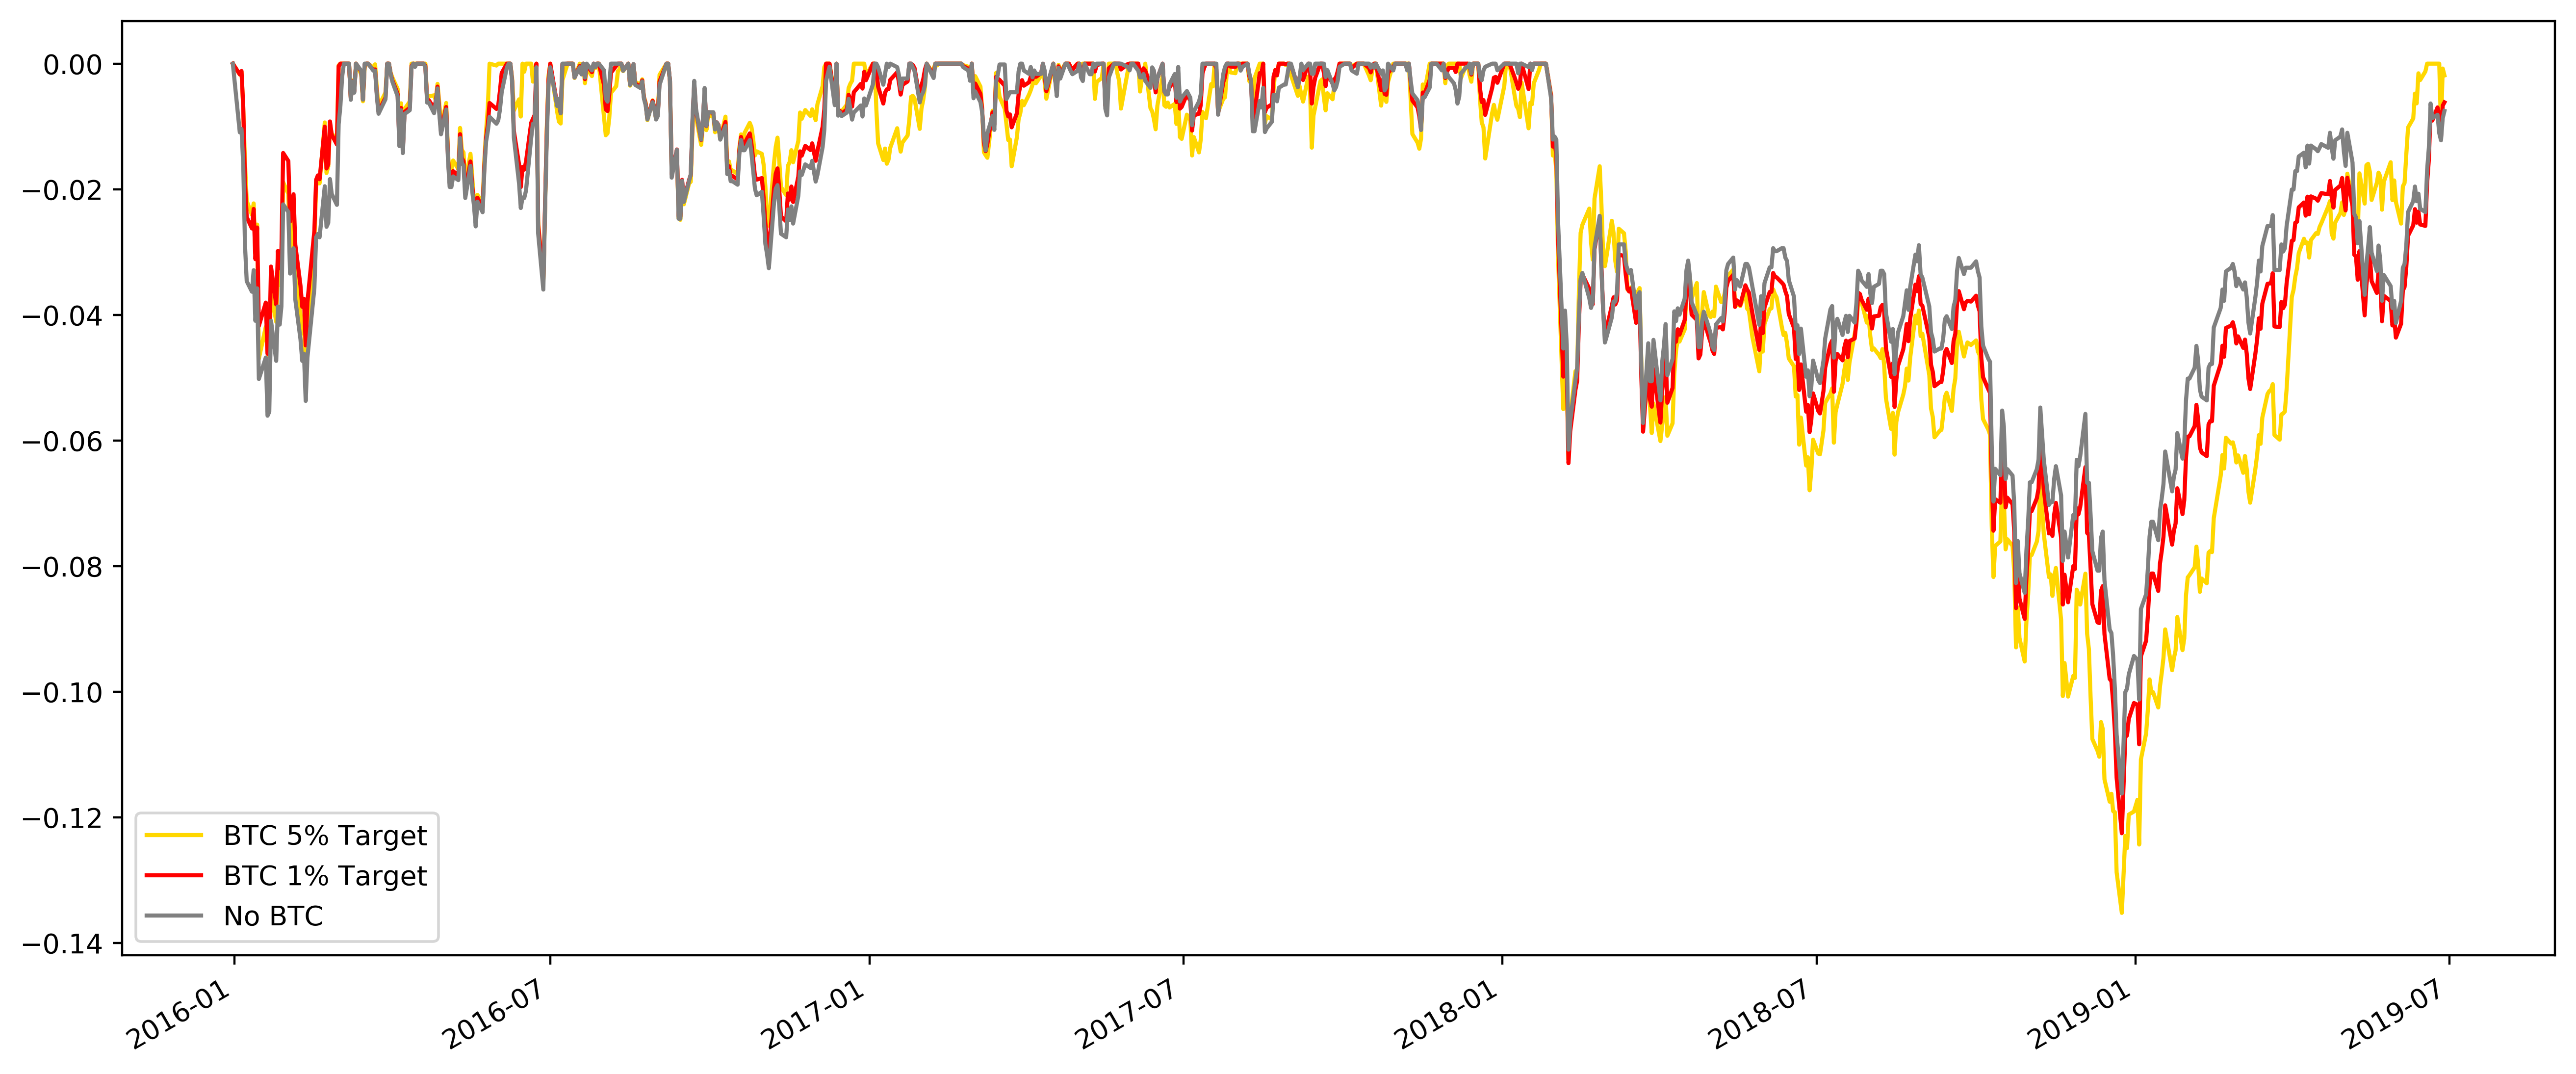

In [75]:
# Plot the results
fig, ax = plt.subplots(figsize=[16, 7])
Daily_Drawdown2.plot(color='gold', label='BTC 5% Target')
Daily_Drawdown1.plot(color='r', label='BTC 1% Target')
Daily_Drawdown3.plot(color='gray', label='No BTC')
plt.legend()
plt.show()

# Просто фонд Vanguard

In [76]:
# Список финансовых инструментов в портфеле
TIKERS = ['VPGDX']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [77]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-12-31  17.330000  17.330000  13.163204
2016-01-01  17.330000  17.330000  13.163204
2016-01-02  17.330000  17.330000  13.163204
2016-01-03  17.330000  17.330000  13.163204
2016-01-04  17.139999  17.139999  13.018887


In [78]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2019-06-24  16.572435  16.572435
2019-06-25  16.523232  16.523232
2019-06-26  16.503548  16.503548
2019-06-27  16.562595  16.562595
2019-06-28  16.582279  16.582279


In [79]:
WEIGHTS = [1]
COMMISSION = 0.000125
DELTA = 0.025

In [59]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_count = 0
    
    context.time = 0

In [80]:
def handle_data(context, data):
    
    if context.time == 0:
        
        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
        context.time += 1
    
    else:
        for i, asset in enumerate(context.assets):
            if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                order_target_percent(asset, context.weights[i])
                
                context.rebalance_count += 1
                
        context.time += 1

In [81]:
perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 6, 30, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [82]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [83]:
qf.get_performance_summary(returns)

annual_volatility     0.068626
annualized_returns    0.070864
cumulative_returns    0.270090
max_drawdown         -0.115286
sharpe_ratio          1.032126
sortino_ratio         1.448949
dtype: float64